<a href="https://colab.research.google.com/github/rcbusinesstechlab/realtime-face-recognition/blob/main/ok_ok_Modify_KAN_Multiple_in_different_graphs_Comparison_SE_and_KAN_SE_(1)_with_Metrics_and_UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

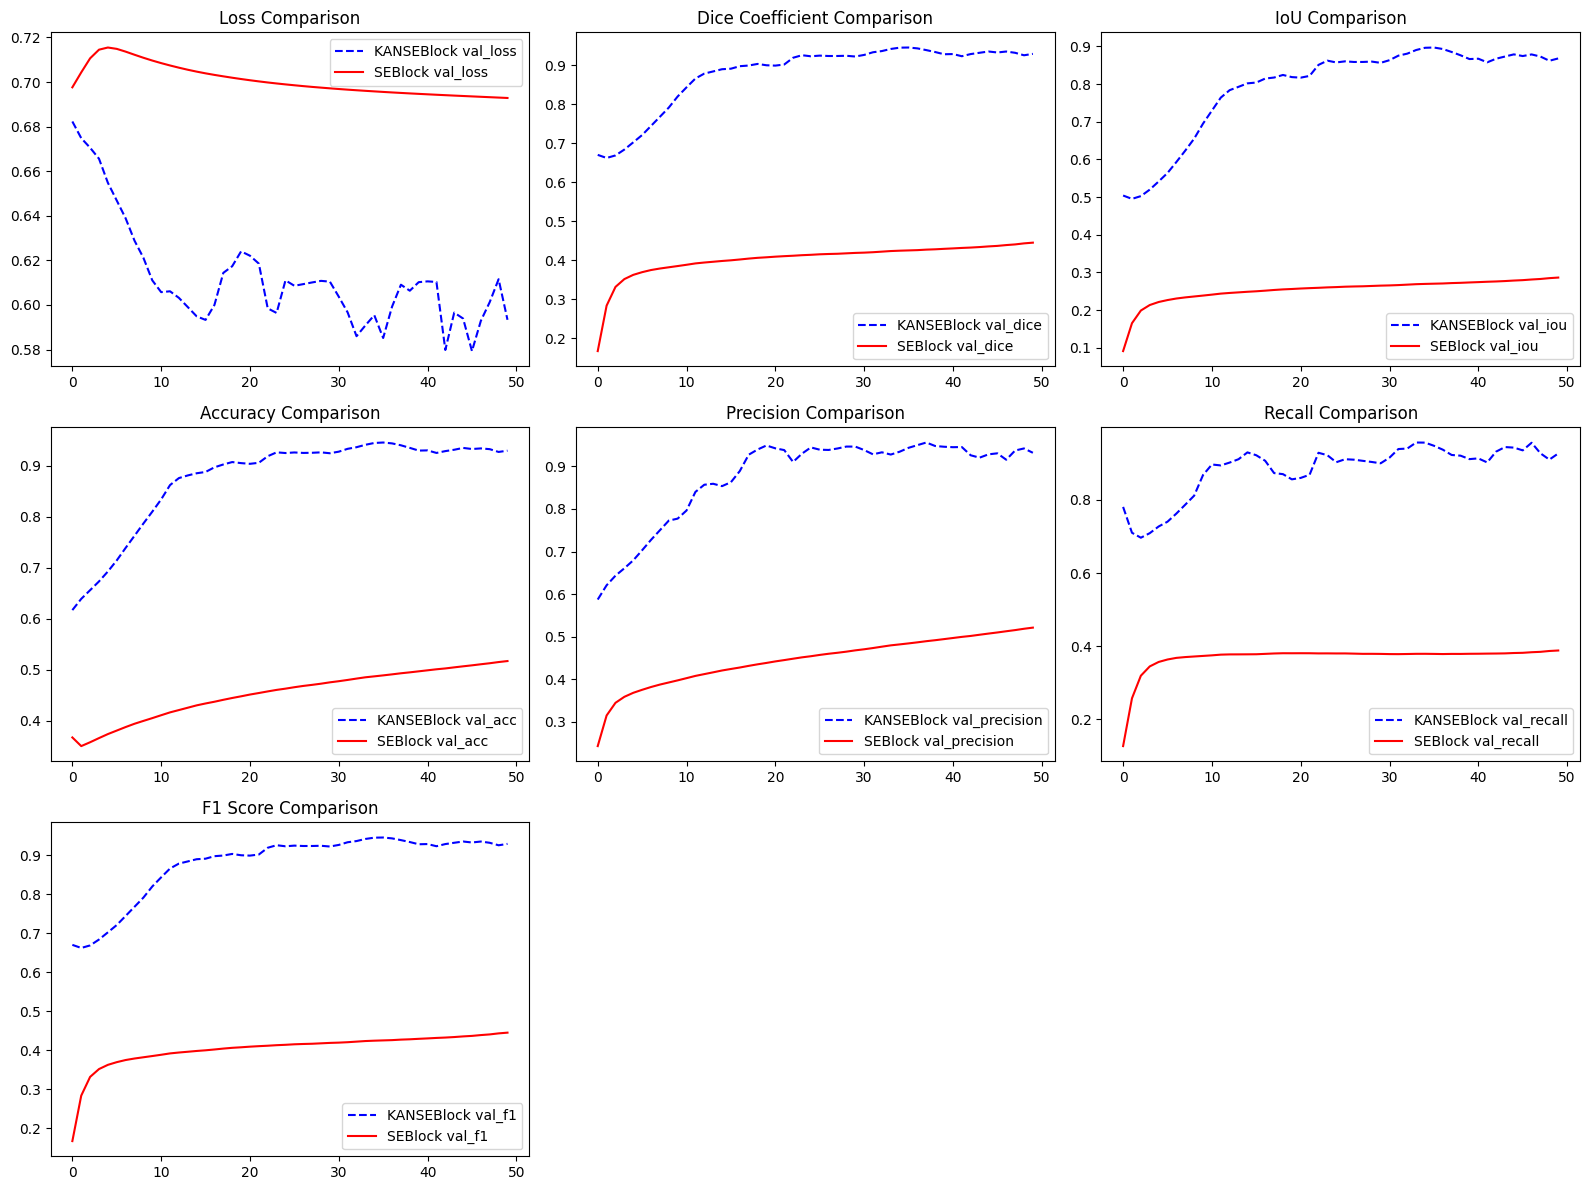

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# ─── Standard SE Block ───────────────────────────────────────
class SEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super().__init__()
        mid_channels = max(1, in_channels // reduction)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Linear(in_channels, mid_channels)
        self.fc2 = nn.Linear(mid_channels, in_channels)
        self.activation = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        B, C, H, W = x.shape
        z = self.global_pool(x).view(B, C)
        h = self.activation(self.fc1(z))
        s = self.sigmoid(self.fc2(h)).view(B, C, 1, 1)
        return x * s

# ─── KANSEBlock ──────────────────────────────────────────────
# ─── Spline Basis ─────────────────────────────────────────────
class SplineBasis(nn.Module):
    def __init__(self, num_basis=16, domain=(-1.0, 1.0)):
        super().__init__()
        self.num_basis = num_basis
        self.domain = domain
        self.register_buffer('knots', torch.linspace(domain[0], domain[1], num_basis))

    def forward(self, x):
        x = x.unsqueeze(-1)
        distances = torch.abs(x - self.knots)
        basis = torch.clamp(1 - distances * self.num_basis, min=0)
        return basis

# ─── KAN Layer 1D ─────────────────────────────────────────────
class KANLayer1D(nn.Module):
    def __init__(self, in_channels, out_channels, num_basis=16):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.num_basis = num_basis
        self.spline = SplineBasis(num_basis)
        self.coeffs = nn.Parameter(torch.randn(out_channels, in_channels, num_basis))

    def forward(self, x):
        # x shape: (batch_size, in_channels)
        basis_vals = self.spline(x)  # shape: (batch_size, in_channels, num_basis)
        out = torch.einsum('bic,oic->bo', basis_vals, self.coeffs)
        return out



# ─── KAN-Enhanced SE Block ───────────────────────────────────
class KANSEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16, num_basis=16):
        super().__init__()
        mid_channels = max(1, in_channels // reduction)
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.kan1 = KANLayer1D(in_channels, mid_channels, num_basis)
        self.kan2 = KANLayer1D(mid_channels, in_channels, num_basis)
        self.activation = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        B, C, H, W = x.shape
        z = self.global_pool(x).view(B, C)
        h = self.activation(self.kan1(z))
        s = self.sigmoid(self.kan2(h)).view(B, C, 1, 1)
        return x * s

# ─── UNet Block with Option for KAN or SE ────────────────────
class UNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_kan=True):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            KANSEBlock(out_channels) if use_kan else SEBlock(out_channels)  # ✅ FIXED: KANSEBlock properly defined
        )

    def forward(self, x):
        return self.conv(x)

# ─── Training & Evaluation Function ───────────────────────────
def train_validate_model(model, train_loader, val_loader, optimizer, criterion, num_epochs=50, device='cpu'):
    history = {'train_loss': [], 'val_loss': [], 'train_dice': [], 'val_dice': [],
               'train_iou': [], 'val_iou': [], 'train_acc': [], 'val_acc': [],
               'train_precision': [], 'val_precision': [], 'train_recall': [], 'val_recall': [],
               'train_f1': [], 'val_f1': []}

    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        train_losses, train_dices, train_ious, train_accs, train_precisions, train_recalls, train_f1s = [], [], [], [], [], [], []

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            probs = torch.sigmoid(outputs)

            train_losses.append(loss.item())
            train_dices.append(dice_coefficient(probs, masks))
            train_ious.append(iou_score(probs, masks))
            acc, p, r, f1 = compute_metrics(probs, masks)
            train_accs.append(acc)
            train_precisions.append(p)
            train_recalls.append(r)
            train_f1s.append(f1)

        model.eval()
        val_losses, val_dices, val_ious, val_accs, val_precisions, val_recalls, val_f1s = [], [], [], [], [], [], []
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                probs = torch.sigmoid(outputs)

                val_losses.append(loss.item())
                val_dices.append(dice_coefficient(probs, masks))
                val_ious.append(iou_score(probs, masks))
                acc, p, r, f1 = compute_metrics(probs, masks)
                val_accs.append(acc)
                val_precisions.append(p)
                val_recalls.append(r)
                val_f1s.append(f1)

        # Store metrics
        for key, values in zip(history.keys(), [train_losses, val_losses, train_dices, val_dices,
                                        train_ious, val_ious, train_accs, val_accs,
                                        train_precisions, val_precisions, train_recalls, val_recalls,  # ✅ Fixed typo here
                                        train_f1s, val_f1s]):
          history[key].append(np.mean(values))

    return model, history

# Dice Coefficient
def dice_coefficient(preds, targets, threshold=0.5, eps=1e-6):
    preds = (preds > threshold).float()
    targets = (targets > threshold).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3))
    dice = (2. * intersection + eps) / (union + eps)
    return dice.mean().item()

# IoU (Jaccard Index)
def iou_score(preds, targets, threshold=0.5, eps=1e-6):
    preds = (preds > threshold).float()
    targets = (targets > threshold).float()
    intersection = (preds * targets).sum(dim=(1, 2, 3))
    union = preds.sum(dim=(1, 2, 3)) + targets.sum(dim=(1, 2, 3)) - intersection
    iou = (intersection + eps) / (union + eps)
    return iou.mean().item()

# Precision, Recall, F1, Accuracy
def compute_metrics(preds, targets, threshold=0.5):
    preds = (preds > threshold).cpu().numpy().astype(int).reshape(-1)
    targets = (targets > threshold).cpu().numpy().astype(int).reshape(-1)

    from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
    precision = precision_score(targets, preds, zero_division=0)
    recall = recall_score(targets, preds, zero_division=0)
    f1 = f1_score(targets, preds, zero_division=0)
    acc = accuracy_score(targets, preds)
    return acc, precision, recall, f1


# ─── Compare Models & Visualize ───────────────────────────────
def compare_models():
    images = torch.rand(100,1,64,64)
    masks = (images > 0.5).float()

    dataset = TensorDataset(images, masks)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=8)

    criterion = nn.BCEWithLogitsLoss()

    model_kan = UNetBlock(1, 1, use_kan=True)
    optimizer_kan = torch.optim.Adam(model_kan.parameters(), lr=1e-3)
    model_kan, history_kan = train_validate_model(model_kan, train_loader, val_loader, optimizer_kan, criterion)

    model_se = UNetBlock(1, 1, use_kan=False)
    optimizer_se = torch.optim.Adam(model_se.parameters(), lr=1e-3)
    model_se, history_se = train_validate_model(model_se, train_loader, val_loader, optimizer_se, criterion)

    # Plot Each Metric Separately
    metrics = ['val_loss', 'val_dice', 'val_iou', 'val_acc', 'val_precision', 'val_recall', 'val_f1']
    titles = ['Loss Comparison', 'Dice Coefficient Comparison', 'IoU Comparison', 'Accuracy Comparison',
              'Precision Comparison', 'Recall Comparison', 'F1 Score Comparison']

    plt.figure(figsize=(16, 12))

    for i, metric in enumerate(metrics):
        plt.subplot(3, 3, i+1)
        plt.plot(history_kan[metric], label=f'KANSEBlock {metric}', linestyle='dashed', color='blue')
        plt.plot(history_se[metric], label=f'SEBlock {metric}', linestyle='solid', color='red')
        plt.title(titles[i])
        plt.legend()

    plt.tight_layout()
    plt.show()

compare_models()


In [2]:

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Assuming SEBlock, KANSEBlock, UNetBlock, dice_coefficient, iou_score, compute_metrics, and train_validate_model are defined in previous cells

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, features=[64, 128, 256, 512], use_kan=True):
        super().__init__()
        self.encoder_blocks = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        prev_channels = in_channels
        for feature in features:
            self.encoder_blocks.append(UNetBlock(prev_channels, feature, use_kan))
            prev_channels = feature

        # Bottleneck
        self.bottleneck = UNetBlock(features[-1], features[-1]*2, use_kan)

        # Decoder
        self.upconvs = nn.ModuleList()
        self.decoder_blocks = nn.ModuleList()
        reversed_features = features[::-1]
        prev_channels = features[-1]*2
        for feature in reversed_features:
            self.upconvs.append(nn.ConvTranspose2d(prev_channels, feature, kernel_size=2, stride=2))
            self.decoder_blocks.append(UNetBlock(prev_channels, feature, use_kan))
            prev_channels = feature

        # Final convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder path
        for enc in self.encoder_blocks:
            x = enc(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)

        # Decoder path
        skip_connections = skip_connections[::-1]
        for idx in range(len(self.upconvs)):
            x = self.upconvs[idx](x)
            skip_connection = skip_connections[idx]

            # Ensure sizes match before concatenation
            if x.shape[2:] != skip_connection.shape[2:]:
                x = nn.functional.interpolate(x, size=skip_connection.shape[2:], mode='nearest') # Using nearest for masks, adjust if images

            x = torch.cat((skip_connection, x), dim=1)
            x = self.decoder_blocks[idx](x)

        return self.final_conv(x)


# Separate function for comparing models
def compare_models():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Using device:", device)

    # --- Redefine Data Loaders within this function's scope ---
    images = torch.rand(100, 1, 64, 64)
    masks = (images > 0.5).float()

    dataset = TensorDataset(images, masks)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=8)
    # ---------------------------------------------------------

    models = {
        "Full UNet (Base)": UNet(in_channels=1, out_channels=1, use_kan=False),
        "Full UNet + SE Block": UNet(in_channels=1, out_channels=1, use_kan=False), # Assuming SE
        "Full UNet + KANSE Block": UNet(in_channels=1, out_channels=1, use_kan=True)
    }

    histories = {}
    criterion = nn.BCEWithLogitsLoss() # Define criterion once

    for name, model in models.items():
        print(f"\nTraining {name}...")
        # Re-initialize optimizer for each model
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

        # Call train_validate_model with the local data loaders
        model, history = train_validate_model(
            model, train_loader, val_loader, optimizer,
            criterion, num_epochs=10, device=device
        )
        histories[name] = history

    # Plotting function is missing, assuming it's defined elsewhere or needs to be added
    # Example placeholder:
    def plot_metrics(histories, metric_key):
        plt.figure(figsize=(10, 6))
        for name, history in histories.items():
            # Check if metric_key exists in history
            if f'val_{metric_key}' in history:
                 plt.plot(history[f'val_{metric_key}'], label=f'{name} Validation {metric_key.capitalize()}')
            else:
                 print(f"Warning: Metric '{metric_key}' not found for model '{name}'")
        plt.title(f'Validation {metric_key.capitalize()} Comparison')
        plt.xlabel('Epoch')
        plt.ylabel(metric_key.capitalize())
        plt.legend()
        plt.grid(True)
        plt.show()


    # Plotting
    plot_metrics(histories, "loss")
    plot_metrics(histories, "dice")
    plot_metrics(histories, "iou")
    plot_metrics(histories, "f1")

# Assuming the call compare_models() is in the subsequent cell (ipython-input-9)

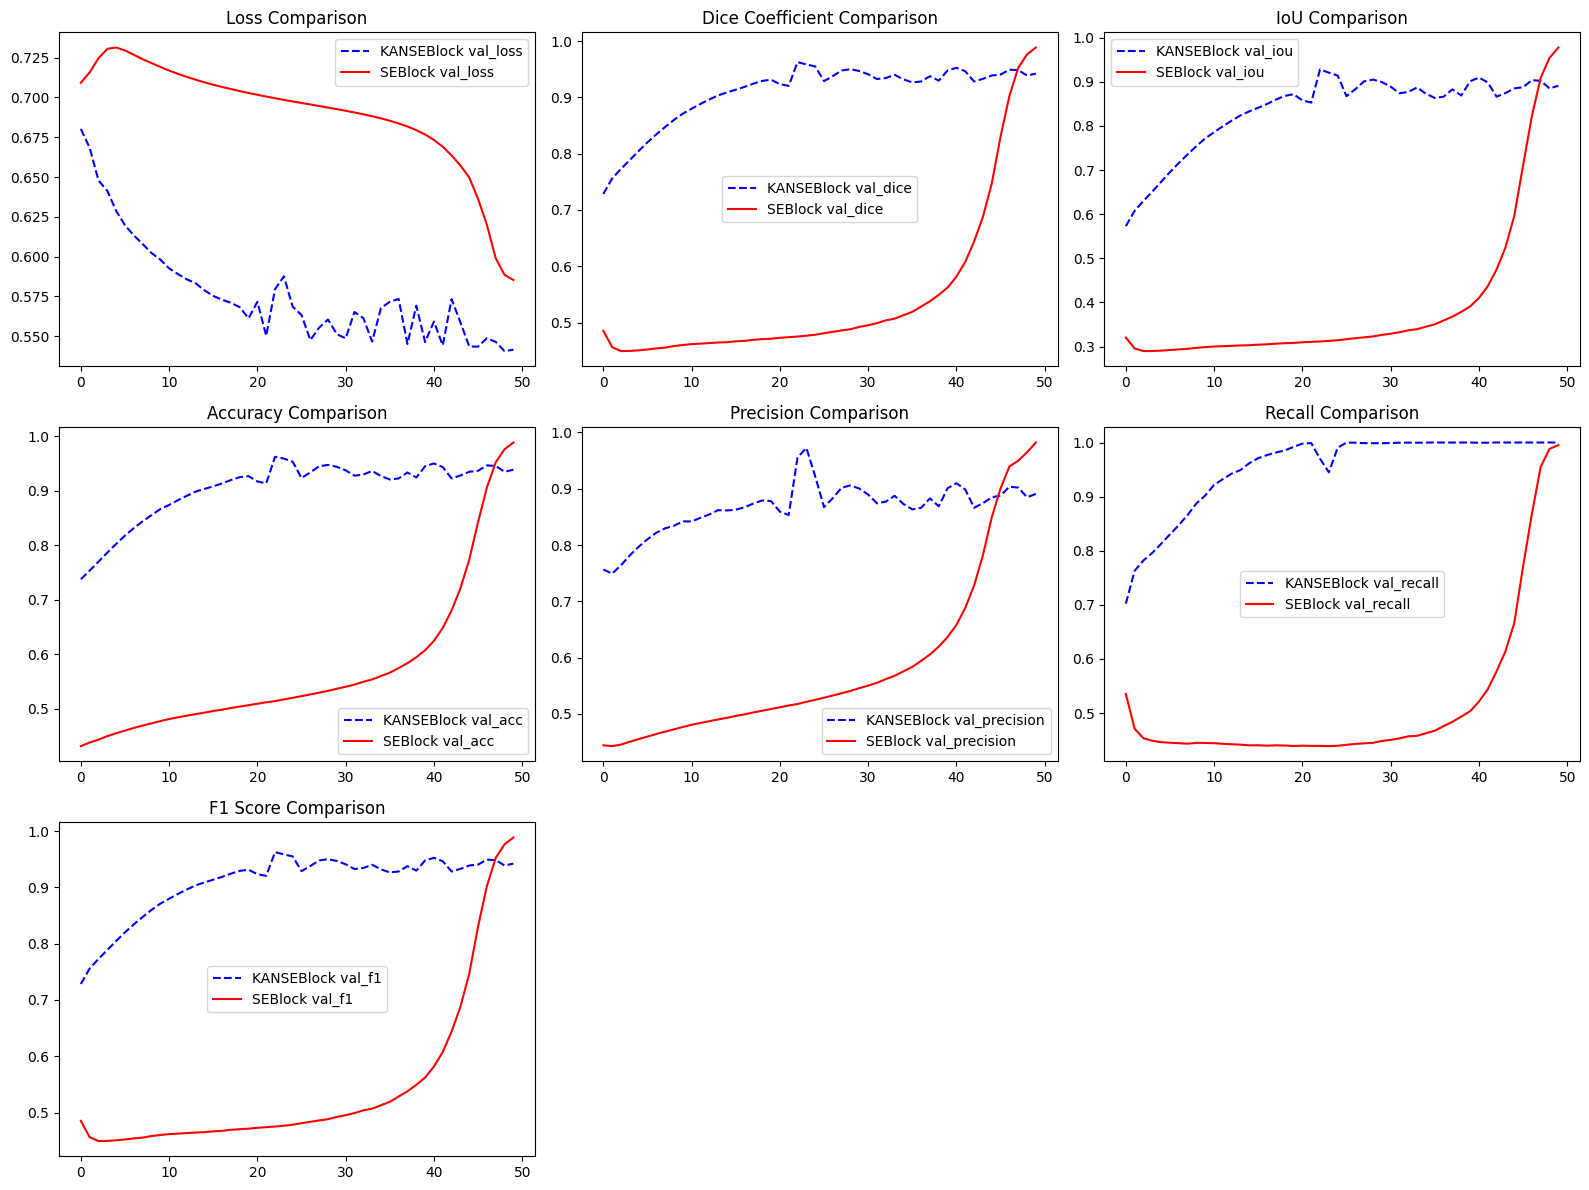

In [7]:
compare_models()